## This code get the GBPUSD weekly data, then clean data and build model to evaluation next week trend. Then save it and create a CSV file as an input to MQL expert that i have wrote before. 
### I cut data start from 2000,1,1 till 2025,1,1

In [1]:
# Importing Libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import random
import talib as ta

In [469]:
# Importing dataset
#dataset = pd.read_csv('D:/AmirAgah/New_Methods_Courses/Data/GBPUSD_DailyData.csv')
dataset = pd.read_csv('D:/AmirAgah/New_Methods_Courses/Data/GBPUSD_WeeklyData.csv')

In [470]:
len(dataset)

7001

In [471]:
dataset.iloc[5689]

Date      2000.01.02 00:00:00
Open                   1.6146
High                   1.6511
Low                    1.6138
Close                  1.6394
Volume                  28316
Name: 5689, dtype: object

In [472]:
dataset['Open'].shift(1).head()

0    NaN
1    0.0
2    0.0
3    0.0
4    0.0
Name: Open, dtype: float64

In [473]:
dataset = dataset.iloc[5689:]

In [474]:
len(dataset)

1312

In [475]:
dataset.head()

,Date,Open,High,Low,Close,Volume
5689,2000.01.02 00:00:00,1.6146,1.6511,1.6138,1.6394,28316
5690,2000.01.09 00:00:00,1.6387,1.6509,1.6313,1.6353,31810
5691,2000.01.16 00:00:00,1.6345,1.6581,1.6297,1.6488,31073
5692,2000.01.23 00:00:00,1.6464,1.6560,1.6155,1.6195,30813
5693,2000.01.30 00:00:00,1.6221,1.6261,1.5830,1.5916,34539


In [476]:
# Drop the rows with zero volume traded
dataset = dataset.drop(dataset[dataset['Volume'] == 0].index)

# Convert the 'Time' column into pandas datetime format
dataset['Date'] = pd.to_datetime(dataset['Date'])
# Set the Time column as index
#dataset.set_index('Date', inplace=True)

In [477]:
dataset.head()

,Date,Open,High,Low,Close,Volume
5689,2000-01-02,1.6146,1.6511,1.6138,1.6394,28316
5690,2000-01-09,1.6387,1.6509,1.6313,1.6353,31810
5691,2000-01-16,1.6345,1.6581,1.6297,1.6488,31073
5692,2000-01-23,1.6464,1.6560,1.6155,1.6195,30813
5693,2000-01-30,1.6221,1.6261,1.5830,1.5916,34539


In [478]:
dataset.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

### Here few indicator will be added to our dataframe.

In [479]:
#Preparing the dataset
dataset['H-L'] = dataset['High'] - dataset['Low']
dataset['O-C'] = dataset['Close'] - dataset['Open']
dataset['3day MA'] = dataset['Close'].shift(1).rolling(window = 3).mean()
dataset['10day MA'] = dataset['Close'].shift(1).rolling(window = 10).mean()
dataset['30day MA'] = dataset['Close'].shift(1).rolling(window = 30).mean()
dataset['50day MA'] = dataset['Close'].shift(1).rolling(window = 50).mean()
dataset['Std_dev']= dataset['Close'].rolling(5).std()
# Create RSI and stochastic
dataset['RSI-9'] = ta.RSI(dataset['Close'].values, timeperiod = 9)
dataset['slowk'],dataset['slowd'] = ta.STOCH(high=dataset['High'].values, low=dataset['Low'].values, 
                                             close=dataset['Close'].values, fastk_period=5, slowk_period=3, 
                                             slowk_matype=0, slowd_period=3, slowd_matype=0)
#STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)

In [480]:
dataset.head()

,Date,Open,High,Low,Close,Volume,H-L,O-C,3day MA,10day MA,30day MA,50day MA,Std_dev,RSI-9,slowk,slowd
5689,2000-01-02,1.6146,1.6511,1.6138,1.6394,28316,0.0373,0.0248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5690,2000-01-09,1.6387,1.6509,1.6313,1.6353,31810,0.0196,-0.0034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5691,2000-01-16,1.6345,1.6581,1.6297,1.6488,31073,0.0284,0.0143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5692,2000-01-23,1.6464,1.6560,1.6155,1.6195,30813,0.0405,-0.0269,1.641167,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5693,2000-01-30,1.6221,1.6261,1.5830,1.5916,34539,0.0431,-0.0305,1.634533,NaN,NaN,NaN,0.022401,NaN,NaN,NaN


#### After we creating indicators now we have few NULL cells, we will drop them all.
#### here we create our target column, named "Price_Rise"

In [481]:
#--- 1 means RISE and 0 means down
dataset['Price_Rise'] = np.where(dataset['Close'].shift(1) > dataset['Open'].shift(1), 0, 1)

In [482]:
dataset[['Date','Close','Open','Price_Rise']].head()

,Date,Close,Open,Price_Rise
5689,2000-01-02,1.6394,1.6146,1
5690,2000-01-09,1.6353,1.6387,0
5691,2000-01-16,1.6488,1.6345,1
5692,2000-01-23,1.6195,1.6464,0
5693,2000-01-30,1.5916,1.6221,1


In [483]:
dataset.isnull().sum()

Date           0
Open           0
High           0
Low            0
Close          0
Volume         0
H-L            0
O-C            0
3day MA        3
10day MA      10
30day MA      30
50day MA      50
Std_dev        4
RSI-9          9
slowk          8
slowd          8
Price_Rise     0
dtype: int64

In [484]:
dataset = dataset.dropna()

In [485]:
len(dataset)

1262

<Axes: xlabel='Price_Rise', ylabel='count'>

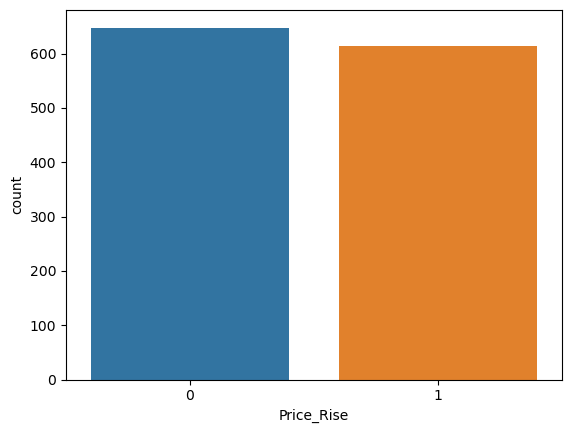

In [486]:
# Some data visualization
import seaborn as sns
sns.countplot(x='Price_Rise', data=dataset)

In [487]:
dataset.corr(numeric_only=True)['Price_Rise'].sort_values()

slowk        -0.382062
RSI-9        -0.325719
slowd        -0.195529
Open         -0.040410
Close        -0.040368
Low          -0.040034
High         -0.038073
O-C           0.000602
3day MA       0.002920
10day MA      0.013543
30day MA      0.020673
H-L           0.020858
50day MA      0.021857
Volume        0.026312
Std_dev       0.040199
Price_Rise    1.000000
Name: Price_Rise, dtype: float64

#### Dataset for training and testing preparation 

In [488]:
# Split data
# X = dataset.drop(['Price_Rise'],axis=1).values
X = dataset.drop(['Date','Open','Close','High','Low','Price_Rise'],axis=1).values
y = dataset['Price_Rise'].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [489]:
# Data scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [490]:
# Create model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

n_features = X_train.shape[1]
X_train.shape

(1009, 11)

In [491]:
# Shape in this array must be as input for model.
model = Sequential()

model.add(Dense(n_features, activation='gelu'))
#model.add(Dropout(0.2))
model.add(Dense(n_features, activation='gelu'))
#model.add(Dropout(0.2))
model.add(Dense(n_features, activation='gelu'))
#model.add(Dropout(0.2))
#model.add(Dense(n_features, activation='gelu'))
#model.add(Dropout(0.2))
#model.add(Dense(n_features, activation='gelu'))
#model.add(Dropout(0.2))
#model.add(Dense(n_features, activation='gelu'))
#model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

# For a binary classification problem
model.compile(loss='binary_crossentropy', optimizer='adam')

In [492]:
# Create call back
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=25)
model.fit(x=X_train, y=y_train, epochs=600, validation_data=(X_test, y_test), callbacks=[early_stop],validation_split=0.2)

Epoch 1/600
32/32 [==============================] - 1s 9ms/step - loss: 0.6826 - val_loss: 0.6782
Epoch 2/600
32/32 [==============================] - 0s 3ms/step - loss: 0.6737 - val_loss: 0.6719
Epoch 3/600
32/32 [==============================] - 0s 3ms/step - loss: 0.6670 - val_loss: 0.6664
Epoch 4/600
32/32 [==============================] - 0s 3ms/step - loss: 0.6593 - val_loss: 0.6604
Epoch 5/600
32/32 [==============================] - 0s 3ms/step - loss: 0.6502 - val_loss: 0.6548
Epoch 6/600
32/32 [==============================] - 0s 4ms/step - loss: 0.6439 - val_loss: 0.6502
Epoch 7/600
32/32 [==============================] - 0s 3ms/step - loss: 0.6391 - val_loss: 0.6469
Epoch 8/600
32/32 [==============================] - 0s 4ms/step - loss: 0.6307 - val_loss: 0.6444
Epoch 9/600
32/32 [==============================] - 0s 4ms/step - loss: 0.6272 - val_loss: 0.6429
Epoch 10/600
32/32 [==============================] - 0s 4ms/step - loss: 0.6237 - val_loss: 0.6404
Epoch 11/

32/32 [==============================] - 0s 4ms/step - loss: 0.4926 - val_loss: 0.5134
Epoch 84/600
32/32 [==============================] - 0s 4ms/step - loss: 0.4885 - val_loss: 0.5115
Epoch 85/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4865 - val_loss: 0.5122
Epoch 86/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4846 - val_loss: 0.5165
Epoch 87/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4867 - val_loss: 0.5098
Epoch 88/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4844 - val_loss: 0.5101
Epoch 89/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4851 - val_loss: 0.5089
Epoch 90/600
32/32 [==============================] - 0s 4ms/step - loss: 0.4859 - val_loss: 0.5095
Epoch 91/600
32/32 [==============================] - 0s 4ms/step - loss: 0.4869 - val_loss: 0.5087
Epoch 92/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4885 - val_loss: 0.5390
Epoch 93/600


32/32 [==============================] - 0s 3ms/step - loss: 0.4708 - val_loss: 0.5089
Epoch 165/600
32/32 [==============================] - 0s 4ms/step - loss: 0.4722 - val_loss: 0.5023
Epoch 166/600
32/32 [==============================] - 0s 4ms/step - loss: 0.4697 - val_loss: 0.4994
Epoch 167/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4679 - val_loss: 0.5003
Epoch 168/600
32/32 [==============================] - 0s 4ms/step - loss: 0.4660 - val_loss: 0.4995
Epoch 169/600
32/32 [==============================] - 0s 4ms/step - loss: 0.4638 - val_loss: 0.5022
Epoch 170/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4705 - val_loss: 0.4994
Epoch 171/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4652 - val_loss: 0.5005
Epoch 172/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4627 - val_loss: 0.5077
Epoch 173/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4703 - val_loss: 0.4983
Epoc

32/32 [==============================] - 0s 3ms/step - loss: 0.4726 - val_loss: 0.4905
Epoch 246/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4656 - val_loss: 0.4903
Epoch 247/600
32/32 [==============================] - 0s 4ms/step - loss: 0.4617 - val_loss: 0.5016
Epoch 248/600
32/32 [==============================] - 0s 4ms/step - loss: 0.4611 - val_loss: 0.4952
Epoch 249/600
32/32 [==============================] - 0s 4ms/step - loss: 0.4675 - val_loss: 0.4904
Epoch 250/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4605 - val_loss: 0.4918
Epoch 251/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4560 - val_loss: 0.4898
Epoch 252/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4573 - val_loss: 0.4914
Epoch 253/600
32/32 [==============================] - 0s 4ms/step - loss: 0.4573 - val_loss: 0.4887
Epoch 254/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4567 - val_loss: 0.4888
Epoc

32/32 [==============================] - 0s 3ms/step - loss: 0.4466 - val_loss: 0.4836
Epoch 327/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4458 - val_loss: 0.4902
Epoch 328/600
32/32 [==============================] - 0s 4ms/step - loss: 0.4606 - val_loss: 0.4821
Epoch 329/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4484 - val_loss: 0.4878
Epoch 330/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4472 - val_loss: 0.5140
Epoch 331/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4496 - val_loss: 0.4962
Epoch 332/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4489 - val_loss: 0.4950
Epoch 333/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4502 - val_loss: 0.4821
Epoch 334/600
32/32 [==============================] - 0s 4ms/step - loss: 0.4425 - val_loss: 0.4979
Epoch 335/600
32/32 [==============================] - 0s 4ms/step - loss: 0.4554 - val_loss: 0.5075
Epoc

32/32 [==============================] - 0s 3ms/step - loss: 0.4374 - val_loss: 0.4792
Epoch 408/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4451 - val_loss: 0.4772
Epoch 409/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4366 - val_loss: 0.4769
Epoch 410/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4377 - val_loss: 0.4822
Epoch 411/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4408 - val_loss: 0.4759
Epoch 412/600
32/32 [==============================] - 0s 4ms/step - loss: 0.4390 - val_loss: 0.4764
Epoch 413/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4404 - val_loss: 0.4781
Epoch 414/600
32/32 [==============================] - 0s 4ms/step - loss: 0.4384 - val_loss: 0.4774
Epoch 415/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4362 - val_loss: 0.4896
Epoch 416/600
32/32 [==============================] - 0s 4ms/step - loss: 0.4394 - val_loss: 0.4780
Epoc

32/32 [==============================] - 0s 3ms/step - loss: 0.4336 - val_loss: 0.4905
Epoch 489/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4348 - val_loss: 0.4860
Epoch 490/600
32/32 [==============================] - 0s 4ms/step - loss: 0.4279 - val_loss: 0.4867
Epoch 491/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4292 - val_loss: 0.4711
Epoch 492/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4298 - val_loss: 0.4820
Epoch 493/600
32/32 [==============================] - 0s 4ms/step - loss: 0.4272 - val_loss: 0.4713
Epoch 494/600
32/32 [==============================] - 0s 4ms/step - loss: 0.4271 - val_loss: 0.4811
Epoch 495/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4249 - val_loss: 0.4792
Epoch 496/600
32/32 [==============================] - 0s 5ms/step - loss: 0.4357 - val_loss: 0.4719
Epoch 497/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4284 - val_loss: 0.4939
Epoc

In [493]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 11)                132       
                                                                 
 dense_121 (Dense)           (None, 11)                132       
                                                                 
 dense_122 (Dense)           (None, 11)                132       
                                                                 
 dense_123 (Dense)           (None, 1)                 12        
                                                                 
Total params: 408 (1.59 KB)
Trainable params: 408 (1.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<Axes: >

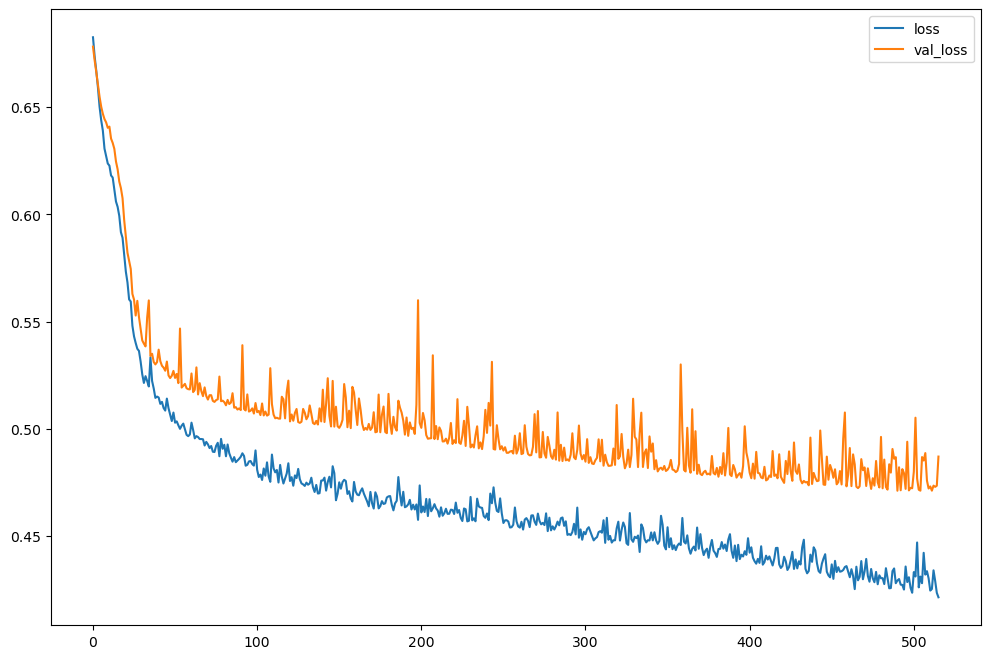

In [494]:
# See result
losses = pd.DataFrame(model.history.history)
losses.plot(figsize=(12,8))

In [495]:
# Predict
#predictions = model.predict_classes(X_test)
predictions = (model.predict(X_test) > 0.5).astype("int32")
#predictions = np.argmax(model.predict(X_test), axis=-1)
#predictions = model.predict(X_test)


from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))


8/8 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       132
           1       0.75      0.82      0.78       121

    accuracy                           0.78       253
   macro avg       0.78      0.78      0.78       253
weighted avg       0.79      0.78      0.78       253

[[99 33]
 [22 99]]


In [496]:
y_test.shape

(253,)

In [497]:
y_hat = y_test.reshape(-1,1)

In [498]:
d = np.array([predictions[:,0],y_test])

In [499]:
res_pd = pd.DataFrame(d).transpose().tail(20)
res_pd.columns=['pred','real']
res_pd

,pred,real
233,0,0
234,0,0
235,1,1
236,0,1
237,0,0
238,0,0
239,1,0
240,1,1
241,1,1
242,1,0


In [501]:
# Save model
from keras.models import load_model

model.save('D:/AmirAgah/Model_Saved/ANN_GBPUSD_Weekly.hdf5')
#model.save('D:/AmirAgah/Project/Final_Prediction_models/ANN_CLASSIFICATION_KERAS/ANN_GBPUSD_Daily_Classification.h5')
#model.save('ANN_GBPUSD_DAILY.h5')

#### Predict for all Data. 
Here we predict all the data that we have with the saved model, then we drop all columns and create a new data frame 
that includes From_Date, To_Date and Riseing Predictions. Then we save it as a CSV file and send it to MQL.

In [507]:
dataset.head()

,Date,Open,High,Low,Close,Volume,H-L,O-C,3day MA,10day MA,30day MA,50day MA,Std_dev,RSI-9,slowk,slowd,Price_Rise
0,2000-12-17,1.4736,1.4842,1.4606,1.4769,49014,0.0236,0.0033,1.456433,1.44266,1.470670,1.515908,0.031463,57.776694,94.109313,77.860765,0
1,2000-12-24,1.4770,1.4983,1.4740,1.4959,34459,0.0243,0.0189,1.468100,1.44515,1.470233,1.512658,0.021581,63.151465,95.464933,91.506131,0
2,2000-12-31,1.4931,1.5098,1.4882,1.5041,39730,0.0216,0.0110,1.482833,1.44959,1.469760,1.509870,0.020365,65.296312,94.030744,94.534997,0
3,2001-01-07,1.5036,1.5106,1.4755,1.4773,45035,0.0351,-0.0263,1.492300,1.45447,1.469560,1.506976,0.013136,53.785310,80.384409,89.960028,0
4,2001-01-14,1.4784,1.4808,1.4626,1.4629,46913,0.0182,-0.0155,1.492433,1.45716,1.468297,1.504132,0.016465,48.605756,49.399073,74.604742,1


In [508]:
new_dataset = dataset
new_dataset.reset_index(drop=True,inplace=True)
new_dataset

,Date,Open,High,Low,Close,Volume,H-L,O-C,3day MA,10day MA,30day MA,50day MA,Std_dev,RSI-9,slowk,slowd,Price_Rise
0,2000-12-17,1.47360,1.48420,1.46060,1.47690,49014,0.02360,0.00330,1.456433,1.442660,1.470670,1.515908,0.031463,57.776694,94.109313,77.860765,0
1,2000-12-24,1.47700,1.49830,1.47400,1.49590,34459,0.02430,0.01890,1.468100,1.445150,1.470233,1.512658,0.021581,63.151465,95.464933,91.506131,0
2,2000-12-31,1.49310,1.50980,1.48820,1.50410,39730,0.02160,0.01100,1.482833,1.449590,1.469760,1.509870,0.020365,65.296312,94.030744,94.534997,0
3,2001-01-07,1.50360,1.51060,1.47550,1.47730,45035,0.03510,-0.02630,1.492300,1.454470,1.469560,1.506976,0.013136,53.785310,80.384409,89.960028,0
4,2001-01-14,1.47840,1.48080,1.46260,1.46290,46913,0.01820,-0.01550,1.492433,1.457160,1.468297,1.504132,0.016465,48.605756,49.399073,74.604742,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,2025-01-19,1.21658,1.25016,1.21593,1.24797,266675,0.03423,0.03139,1.226260,1.251462,1.283891,1.275502,0.017614,43.468833,29.165913,17.709886,1
1258,2025-01-26,1.24658,1.25228,1.23861,1.23930,275131,0.01367,-0.00728,1.228330,1.250088,1.283343,1.275208,0.013855,39.971541,47.734734,28.608101,0
1259,2025-02-02,1.22944,1.25496,1.22490,1.24000,300266,0.03006,0.01056,1.234610,1.248738,1.281941,1.274795,0.013603,40.407034,65.588587,47.496412,1
1260,2025-02-09,1.23692,1.26300,1.23323,1.25856,245780,0.02977,0.02164,1.242423,1.245456,1.279983,1.274254,0.015466,51.008708,71.162258,61.495193,0


In [509]:
df_for_predict = new_dataset.drop(['Open','Close','High','Low','Price_Rise'],axis=1)

In [510]:
df_for_predict.head()

,Date,Volume,H-L,O-C,3day MA,10day MA,30day MA,50day MA,Std_dev,RSI-9,slowk,slowd
0,2000-12-17,49014,0.0236,0.0033,1.456433,1.44266,1.470670,1.515908,0.031463,57.776694,94.109313,77.860765
1,2000-12-24,34459,0.0243,0.0189,1.468100,1.44515,1.470233,1.512658,0.021581,63.151465,95.464933,91.506131
2,2000-12-31,39730,0.0216,0.0110,1.482833,1.44959,1.469760,1.509870,0.020365,65.296312,94.030744,94.534997
3,2001-01-07,45035,0.0351,-0.0263,1.492300,1.45447,1.469560,1.506976,0.013136,53.785310,80.384409,89.960028
4,2001-01-14,46913,0.0182,-0.0155,1.492433,1.45716,1.468297,1.504132,0.016465,48.605756,49.399073,74.604742


In [511]:
df_for_predict['Date'].iloc[72].day

5

In [ ]:
#### Buikd To_Date column

In [512]:
df_for_predict['To_Date'] = df_for_predict['Date'].shift(-1)
df_for_predict = df_for_predict.dropna()

In [513]:
df_for_predict

,Date,Volume,H-L,O-C,3day MA,10day MA,30day MA,50day MA,Std_dev,RSI-9,slowk,slowd,To_Date
0,2000-12-17,49014,0.02360,0.00330,1.456433,1.442660,1.470670,1.515908,0.031463,57.776694,94.109313,77.860765,2000-12-24
1,2000-12-24,34459,0.02430,0.01890,1.468100,1.445150,1.470233,1.512658,0.021581,63.151465,95.464933,91.506131,2000-12-31
2,2000-12-31,39730,0.02160,0.01100,1.482833,1.449590,1.469760,1.509870,0.020365,65.296312,94.030744,94.534997,2001-01-07
3,2001-01-07,45035,0.03510,-0.02630,1.492300,1.454470,1.469560,1.506976,0.013136,53.785310,80.384409,89.960028,2001-01-14
4,2001-01-14,46913,0.01820,-0.01550,1.492433,1.457160,1.468297,1.504132,0.016465,48.605756,49.399073,74.604742,2001-01-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2025-01-12,258813,0.02058,-0.00316,1.239797,1.258969,1.285474,1.276432,0.019249,21.292242,8.923656,15.675530,2025-01-19
1257,2025-01-19,266675,0.03423,0.03139,1.226260,1.251462,1.283891,1.275502,0.017614,43.468833,29.165913,17.709886,2025-01-26
1258,2025-01-26,275131,0.01367,-0.00728,1.228330,1.250088,1.283343,1.275208,0.013855,39.971541,47.734734,28.608101,2025-02-02
1259,2025-02-02,300266,0.03006,0.01056,1.234610,1.248738,1.281941,1.274795,0.013603,40.407034,65.588587,47.496412,2025-02-09


In [514]:
df_for_predict.columns

Index(['Date', 'Volume', 'H-L', 'O-C', '3day MA', '10day MA', '30day MA',
       '50day MA', 'Std_dev', 'RSI-9', 'slowk', 'slowd', 'To_Date'],
      dtype='object')

In [515]:
# prepair data for predicting by model

X_for_prediction = df_for_predict.drop(['Date','To_Date'],axis=1).values
#y = dataset['Price_Rise'].values

In [516]:
X_for_prediction.shape

(1261, 11)

In [517]:
scaleld_X_for_prediction = scaler.transform(X_for_prediction)

In [518]:
scaleld_X_for_prediction

array([[0.02946818, 0.08487219, 0.63475177, ..., 0.5854377 , 0.96188282,
        0.81327174],
       [0.01791196, 0.08805604, 0.70390071, ..., 0.65418801, 0.9758652 ,
        0.96259013],
       [0.02209697, 0.07577549, 0.66888298, ..., 0.68162338, 0.96107243,
        0.99573437],
       ...,
       [0.20899822, 0.03970709, 0.58785461, ..., 0.35768667, 0.48355791,
        0.27431013],
       [0.22895464, 0.11425453, 0.66693262, ..., 0.36325718, 0.66770929,
        0.48100097],
       [0.18569441, 0.1129355 , 0.7160461 , ..., 0.49886637, 0.72519824,
        0.63418671]])

In [519]:
#Model Load
prediction_model = load_model('D:/AmirAgah/Model_Saved/ANN_GBPUSD_Weekly.hdf5')

In [520]:
#give a data _ here i may see the result of model probaility.
prediction_last_data = (prediction_model.predict(scaleld_X_for_prediction)>0.5).astype('int32')

40/40 [==============================] - 0s 2ms/step


In [521]:
predicted_values = pd.DataFrame(prediction_last_data)
predicted_values.columns = (['Predict_values'])
predicted_values

,Predict_values
0,0
1,0
2,0
3,0
4,1
...,...
1256,1
1257,1
1258,0
1259,1


In [522]:
df_for_predict

,Date,Volume,H-L,O-C,3day MA,10day MA,30day MA,50day MA,Std_dev,RSI-9,slowk,slowd,To_Date
0,2000-12-17,49014,0.02360,0.00330,1.456433,1.442660,1.470670,1.515908,0.031463,57.776694,94.109313,77.860765,2000-12-24
1,2000-12-24,34459,0.02430,0.01890,1.468100,1.445150,1.470233,1.512658,0.021581,63.151465,95.464933,91.506131,2000-12-31
2,2000-12-31,39730,0.02160,0.01100,1.482833,1.449590,1.469760,1.509870,0.020365,65.296312,94.030744,94.534997,2001-01-07
3,2001-01-07,45035,0.03510,-0.02630,1.492300,1.454470,1.469560,1.506976,0.013136,53.785310,80.384409,89.960028,2001-01-14
4,2001-01-14,46913,0.01820,-0.01550,1.492433,1.457160,1.468297,1.504132,0.016465,48.605756,49.399073,74.604742,2001-01-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2025-01-12,258813,0.02058,-0.00316,1.239797,1.258969,1.285474,1.276432,0.019249,21.292242,8.923656,15.675530,2025-01-19
1257,2025-01-19,266675,0.03423,0.03139,1.226260,1.251462,1.283891,1.275502,0.017614,43.468833,29.165913,17.709886,2025-01-26
1258,2025-01-26,275131,0.01367,-0.00728,1.228330,1.250088,1.283343,1.275208,0.013855,39.971541,47.734734,28.608101,2025-02-02
1259,2025-02-02,300266,0.03006,0.01056,1.234610,1.248738,1.281941,1.274795,0.013603,40.407034,65.588587,47.496412,2025-02-09


In [523]:
print(predicted_values.shape)
print(df_for_predict.shape)

(1261, 1)
(1261, 13)


In [524]:
# Contact with the other Data Framedf_for_predict
predicted_values_dataframe = pd.concat([df_for_predict, predicted_values],axis=1)
#predicted_values_dataframe.iloc[1075:1080]
predicted_values_dataframe

,Date,Volume,H-L,O-C,3day MA,10day MA,30day MA,50day MA,Std_dev,RSI-9,slowk,slowd,To_Date,Predict_values
0,2000-12-17,49014,0.02360,0.00330,1.456433,1.442660,1.470670,1.515908,0.031463,57.776694,94.109313,77.860765,2000-12-24,0
1,2000-12-24,34459,0.02430,0.01890,1.468100,1.445150,1.470233,1.512658,0.021581,63.151465,95.464933,91.506131,2000-12-31,0
2,2000-12-31,39730,0.02160,0.01100,1.482833,1.449590,1.469760,1.509870,0.020365,65.296312,94.030744,94.534997,2001-01-07,0
3,2001-01-07,45035,0.03510,-0.02630,1.492300,1.454470,1.469560,1.506976,0.013136,53.785310,80.384409,89.960028,2001-01-14,0
4,2001-01-14,46913,0.01820,-0.01550,1.492433,1.457160,1.468297,1.504132,0.016465,48.605756,49.399073,74.604742,2001-01-21,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2025-01-12,258813,0.02058,-0.00316,1.239797,1.258969,1.285474,1.276432,0.019249,21.292242,8.923656,15.675530,2025-01-19,1
1257,2025-01-19,266675,0.03423,0.03139,1.226260,1.251462,1.283891,1.275502,0.017614,43.468833,29.165913,17.709886,2025-01-26,1
1258,2025-01-26,275131,0.01367,-0.00728,1.228330,1.250088,1.283343,1.275208,0.013855,39.971541,47.734734,28.608101,2025-02-02,0
1259,2025-02-02,300266,0.03006,0.01056,1.234610,1.248738,1.281941,1.274795,0.013603,40.407034,65.588587,47.496412,2025-02-09,1


In [525]:
predicted_values_dataframe.columns

Index(['Date', 'Volume', 'H-L', 'O-C', '3day MA', '10day MA', '30day MA',
       '50day MA', 'Std_dev', 'RSI-9', 'slowk', 'slowd', 'To_Date',
       'Predict_values'],
      dtype='object')

In [526]:
dataframe_ready_for_mql = predicted_values_dataframe.drop(['Volume', 'H-L', 'O-C', '3day MA', '10day MA', '30day MA',
       '50day MA', 'RSI-9', 'slowk', 'slowd','Std_dev'],axis=1)
dataframe_ready_for_mql

,Date,To_Date,Predict_values
0,2000-12-17,2000-12-24,0
1,2000-12-24,2000-12-31,0
2,2000-12-31,2001-01-07,0
3,2001-01-07,2001-01-14,0
4,2001-01-14,2001-01-21,1
...,...,...,...
1256,2025-01-12,2025-01-19,1
1257,2025-01-19,2025-01-26,1
1258,2025-01-26,2025-02-02,0
1259,2025-02-02,2025-02-09,1


In [530]:
dataframe_ready_for_mql.to_csv('D:/AmirAgah/Model_Saved/mql_csv_data.csv',sep=";")

In [531]:
dataframe_ready_for_mql.to_csv('D:/AmirAgah/Model_Saved/mql_csv_data02.csv',sep=",")

In [532]:
dataframe_ready_for_mql.to_csv('D:/AmirAgah/Model_Saved/mql_csv_data03.csv',sep="@")

In [533]:
### END HERE.

# Prediction for one entry data .

For prediction i have to do below items :
- load model
- make a features as input model from data
- predict by model

In [396]:
# befor makoing that i do the below procedure to find out next day trned .
new_X_test = X_test[len(X_test)-5:][:]

(model.predict(new_X_test)>0.5).astype('int32')

1/1 [==============================] - 0s 38ms/step


array([[1],
       [1],
       [1],
       [1],
       [1]])

In [397]:
# I try to find solution for make new data from 
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1100 non-null   datetime64[ns]
 1   Open        1100 non-null   float64       
 2   High        1100 non-null   float64       
 3   Low         1100 non-null   float64       
 4   Close       1100 non-null   float64       
 5   Volume      1100 non-null   int64         
 6   H-L         1100 non-null   float64       
 7   O-C         1100 non-null   float64       
 8   3day MA     1100 non-null   float64       
 9   10day MA    1100 non-null   float64       
 10  30day MA    1100 non-null   float64       
 11  50day MA    1100 non-null   float64       
 12  Std_dev     1100 non-null   float64       
 13  RSI-9       1100 non-null   float64       
 14  slowk       1100 non-null   float64       
 15  slowd       1100 non-null   float64       
 16  Price_Rise  1100 non-nul

In [398]:
new_item = dataset.drop(['Date','Open','Close','High','Low','Price_Rise'],axis=1).iloc[len(dataset)-1]

In [225]:
new_item = new_item.values.reshape(1,-1)

In [226]:
new_item.shape

(1, 10)

In [227]:
scaleld_item = scaler.transform(new_item)

In [228]:
#Model Load
#give a data _ here i may see the result of model probaility.
prediction_last_item = (model.predict(new_item)>0.5).astype('int32')

1/1 [==============================] - 0s 18ms/step


In [229]:
prediction_last_item

array([[1]])